We want to convert the routines below to use the BasicCameraGUI as the base and test with the existing polar mapping methods.

In [1]:
import numpy as np
from src.visualisers.camera_gui import BasicCameraGUI, display, DecomposeFrame

In [2]:
from src.sources.polar_mapping import (
    generateLUT, setup_reduced_res, reduce_resolution, convert_image, forward_quad
)

In [3]:
class PolarGUI(BasicCameraGUI):
    """Convert base camera into polar co-ordinates."""
    
    def __init__(self, src=0, phase_width=256):
        # Call parent init
        super().__init__(src)
        
        # Capture a frame to set image sizes
        _, frame = self.cam.read()
        Y = frame[:, :, 0]
        self.centre = np.asarray(Y.shape) // 2
        self.radius = self.centre.max()
        self.phase_width = phase_width
        # Generate LUT
        self.LUT = generateLUT(self.radius, phase_width=phase_width)
        
    def update_image(self):
        # Get frame
        (readsuccessful, frame) = self.cam.read()
        Y = frame[:, :, 0]
        converted = convert_image(Y, self.LUT)
        display(converted, self.original_image)
        return converted

In [4]:
polar = PolarGUI()
polar.run()

This appears to work.
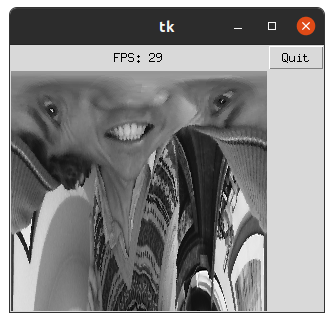

Now we want to split the visual field - does our forward quad do this?

In [4]:
class QuadPolar(PolarGUI):
    """Show different portions of visual field."""
    def __init__(self, src=0, phase_width=256):
        # Call parent init
        super().__init__(src, phase_width)
        
        # Add a decompose frame to show quad
        self.frame = DecomposeFrame(self.window, width=128, height=128)
        
    def update_image(self):
        # Get frame
        (readsuccessful, frame) = self.cam.read()
        Y = frame[:, :, 0]
        converted = convert_image(Y, self.LUT)
        display(converted, self.original_image)
        images = forward_quad(converted)
        self.frame.update(images)
        return converted

In [6]:
qp = QuadPolar()
qp.run()

Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 85, in <lambda>
    self.window.after(20, func=lambda: self.update_all())
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 84, in update_all
    self.update_fps()
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 78, in update_fps
    self.fps_label.configure(text=f'FPS: {fps}')
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1485, in configure
    return self._configure('configure', cnf, kw)
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1476, in _confi

Now need to convert this last reduced GUI...

In [7]:
import tkinter as tk

class CamGUIReduced(QuadPolar):

    def __init__(self, src=0, phase_width=256):
        # Call parent init
        super().__init__(src, phase_width)
        # Setup reduced resolution parameters
        self.precomputed = setup_reduced_res(self.phase_width)
        # frame and label for the reduced resolution frame
        reduced_frame = tk.Frame(self.window)
        reduced_frame.pack(side=tk.LEFT, expand=True, fill=tk.BOTH)
        self.reduced_image = tk.Label(reduced_frame)
        self.reduced_image.pack(padx=5, pady=5)

    def update_image(self):
        converted = super().update_image()
        # Show reduced image
        output_list, output_image = reduce_resolution(
            converted, output_display=True, precomputed=self.precomputed)
        display(output_image, self.reduced_image)
        return converted

In [8]:
reduced = CamGUIReduced()
reduced.run()

Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 85, in <lambda>
    self.window.after(20, func=lambda: self.update_all())
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 84, in update_all
    self.update_fps()
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 78, in update_fps
    self.fps_label.configure(text=f'FPS: {fps}')
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1485, in configure
    return self._configure('configure', cnf, kw)
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1476, in _confi

In [ ]:


class CameraGUI:

    def __init__(self, src=0, phase_width=256):
        # Set Up Camera and LUT for Polar Mapping
        self.cam = cv2.VideoCapture(src)
        self.cam.set(cv2.CAP_PROP_CONVERT_RGB, 0)
        # Capture a frame to set image sizes
        _, frame = self.cam.read()
        Y = frame[:, :, 0]
        self.centre = np.asarray(Y.shape) // 2
        self.final_radius = self.centre.min()
        self.phase_width = phase_width
        # Generate LUT
        self.LUT = generateLUT(
            self.centre, self.final_radius, phase_width=phase_width)
        # Setup gui
        self.window = tk.Tk()
        # label for the original video frame
        self.original_image = tk.Label(master=self.window)
        self.original_image.grid(row=0, column=0)
        # label for the polar video frame
        self.polar_image = tk.Label(master=self.window)
        self.polar_image.grid(row=0, column=1)
        # Label for right image
        self.right_image = tk.Label(master=self.window)
        self.right_image.grid(row=0, column=2)
        # Label for left image
        self.left_image = tk.Label(master=self.window)
        self.left_image.grid(row=0, column=3)

        # label for fps
        self.fps_label = tk.Label(master=self.window)
        self.fps_label.grid(row=2, column=0)
        # arbitrary 5 frame average FPS
        self.fps_label._frame_times = deque([0] * 5)
        # quit button
        self.quit_button = tk.Button(
            master=self.window, text='Quit', command=lambda: self.quit_())
        self.quit_button.grid(row=2, column=1)
        # setup the update callback
        self.window.after(0, func=lambda: self.update_all())

    def update_image(self):
        # Get frame
        (readsuccessful, frame) = self.cam.read()
        Y = frame[:, :, 0]
        # Show original frame
        display(cv2.pyrDown(Y), self.original_image)
        # Can change this to internal method
        converted = img2polar(Y, self.centre, self.final_radius,
                              self.LUT, phase_width=self.phase_width)
        display(converted, self.polar_image)
        # Show left / right hemisphere images
        rows, cols = converted.shape
        # right_image = np.flipud(converted[:, :cols//2].T)
        # left_image = np.fliplr(converted[:, cols//2:].T)
        right_image = converted[:, :cols // 2].T
        left_image = np.flip(converted[:, cols // 2:].T)
        display(right_image, self.right_image)
        display(left_image, self.left_image)
        # Update Window
        self.window.update()

    def update_fps(self):
        frame_times = self.fps_label._frame_times
        frame_times.rotate()
        frame_times[0] = time.time()
        sum_of_deltas = frame_times[0] - frame_times[-1]
        count_of_deltas = len(frame_times) - 1
        try:
            fps = int(float(count_of_deltas) / sum_of_deltas)
        except ZeroDivisionError:
            fps = 0
        self.fps_label.configure(text=f'FPS: {fps}')

    def update_all(self):
        self.update_image()
        self.update_fps()
        self.window.after(20, func=lambda: self.update_all())

    def run(self):
        self.window.mainloop()

    def quit_(self):
        self.cam.release()
        self.window.destroy()


class CamGUIReduced(CameraGUI):

    def __init__(self, src=0, phase_width=256):
        # Call parent init
        super().__init__(src, phase_width)
        # Setup reduced resolution parameters
        self.precomputed = setup_reduced_res(self.phase_width)
        # label for the reduced resolution frame
        self.reduced_image = tk.Label(master=self.window)
        self.reduced_image.grid(row=0, column=4)

    def update_image(self):
        # Can maybe refactor top bit so we can call with a super()
        # Get frame
        (readsuccessful, frame) = self.cam.read()
        Y = frame[:, :, 0]
        # Show original frame
        display(cv2.pyrDown(Y), self.original_image)
        # Can change this to internal method
        converted = img2polar(Y, self.centre, self.final_radius,
                              self.LUT, phase_width=self.phase_width)
        display(converted, self.polar_image)
        # Show left / right hemisphere images
        rows, cols = converted.shape
        # right_image = np.flipud(converted[:, :cols//2].T)
        # left_image = np.fliplr(converted[:, cols//2:].T)
        right_image = converted[:, :cols // 2].T
        left_image = np.flip(converted[:, cols // 2:].T)
        display(right_image, self.right_image)
        display(left_image, self.left_image)
        # Show reduced image
        output_list, output_image = reduce_resolution(
            converted, output_display=True, precomputed=self.precomputed)
        display(output_image, self.reduced_image)
        # Update Window
        self.window.update()
